# Intensity and spatial features from CSLs for VAE_SBF2
## Extract features for all experiments of the SBF2 dataset

```
scripts/extract_features.sh
```

This extracts:
- per cluster mean intensity features
- per cluster pair co-occurence scores
    - Co-occurrence scores are extracted with logarithmically growing distances, with 28 intervals, up to the maximum distance of 320 pixels
- per cluster and connected component statistics
    - computed statistics are: area, circularity, extent and elongation

The features are saved in an anndata object per data directory:
- `features_seedX.h5ad` containing features using the original clustering
- `features_seedX_annotation.h5ad` containing features using the annotated clustering

Note that the calculation of co-occurrence scores is time and memory intensive. 
You can adjust the CO_OCC_CHUNK_SIZE value if the processes runs out of memory, and run the feature extraction with multiple processes to speed the computation up.

## Export calculated features as csv
To extract a csv of mean intensity and size features and other metadata columns, execute the following code:

```python
from campa.tl import Experiment, FeatureExtractor
import os

exp = Experiment.from_dir('VAE_SBF2/CondVAE_siRNA-CC')
for data_dir in exp.data_params['data_dirs']:
    # clusters
    extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_seed1.h5ad'))
    extr.extract_intensity_csv(obs=['well_name', 'siRNA', 'TR', 'cell_cycle'])

    extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_seed2.h5ad'))
    extr.extract_intensity_csv(obs=['well_name', 'siRNA', 'TR', 'cell_cycle'])

    extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_seed3.h5ad'))
    extr.extract_intensity_csv(obs=['well_name', 'siRNA', 'TR', 'cell_cycle'])

    # annotated clusters
    extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad'))
    extr.extract_intensity_csv(obs=['well_name', 'perturbation_duration', 'TR'])
```

## Note on co-occurrence scores
Co-occurrence scores for the SBF2 data were calculated in 2 batches: small and large distances. The resulting features files were merged with the code below. 
When rerunning, you can just use the code provided in the script to extract all co-occurrence scores at once. 

```python
def join_co_occ_scores(exp, name='features_annotation', save_name=None):
    if save_name is None:
        save_name = name
    for data_dir in exp.data_params['data_dirs']:
        print(data_dir)
        p1 = os.path.join(exp.full_path, 'aggregated/full_data', data_dir, f'{name}.h5ad')
        p2 = os.path.join(exp.full_path, 'aggregated/full_data', data_dir, f'{name}2.h5ad')
        extr1 = FeatureExtractor.from_adata(p1)
        extr2 = FeatureExtractor.from_adata(p2)
        
        # create joint adata
        adata = extr1.adata
        adata.uns['co_occurrence_params']['interval'] = np.concatenate([extr1.adata.uns['co_occurrence_params']['interval'], 
                                                                        extr2.adata.uns['co_occurrence_params']['interval'][1:]])
        for c1 in extr1.clusters:
            for c2 in extr1.clusters:
                adata.obsm[f'co_occurrence_{c1}_{c2}'] = pd.concat([extr1.adata.obsm[f'co_occurrence_{c1}_{c2}'], 
                               extr2.adata.obsm[f'co_occurrence_{c1}_{c2}']], axis=1, ignore_index=True)
                adata.obsm[f'co_occurrence_{c1}_{c2}'].columns =  adata.obsm[f'co_occurrence_{c1}_{c2}'].columns.astype('str')
        # set exp name in adata.uns
        adata.uns['params']['exp_name'] = exp.dir + '/' + exp.name
        adata.write(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, f'{save_name}.h5ad'))

exp = Experiment.from_dir('VAE_SBF2/CondVAE_siRNA-CC')
join_co_occ_scores(exp, name='features_seed3_annotation_cytoplasm', save_name='features_seed3_annotation_cytoplasm')
join_co_occ_scores(exp, name='features_seed3_annotation', save_name='features_seed3_annotation')
```

# Explore features
In the following, we plot intensity, co-occurence, and object features using plotting function provided in campa.pl

We use `features_seed3_annotation.h5ad`, for plotting results from any other clustering, change features_fname.

In [1]:
from campa.tl import Experiment, FeatureExtractor
import os
from campa.pl import plot_mean_intensity, get_intensity_change, plot_intensity_change, plot_mean_size, plot_size_change, plot_object_stats
from campa.pl import plot_co_occurrence, plot_co_occurrence_grid
import anndata as ad
from campa.utils import init_logging
import logging
init_logging(level=logging.WARNING)

In [2]:
exp = Experiment.from_dir('VAE_SBF2/CondVAE_siRNA-CC')
features_fname = 'features_seed3_annotation.h5ad'

# load extracted features for  clustering_res0.9_sub-0.33_seed3, annotation
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, features_fname)) for data_dir in exp.data_params['data_dirs']]


## Mean and per cluster intensity

In [3]:
# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata = ad.concat(adatas, index_unique='-')

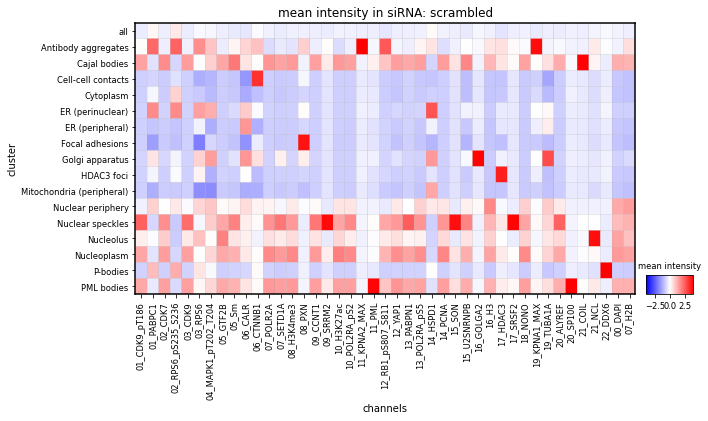

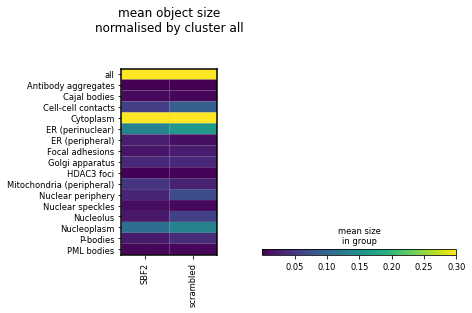

In [4]:
plot_mean_intensity(adata, groupby='cluster', limit_to_groups={'siRNA':'scrambled'}, dendrogram=False, layer=None,
    standard_scale='var', cmap='bwr', vmax=4, vmin=-4)
plot_mean_size(adata, groupby_row='cluster', groupby_col='siRNA', normby_row='all', vmax=0.3)

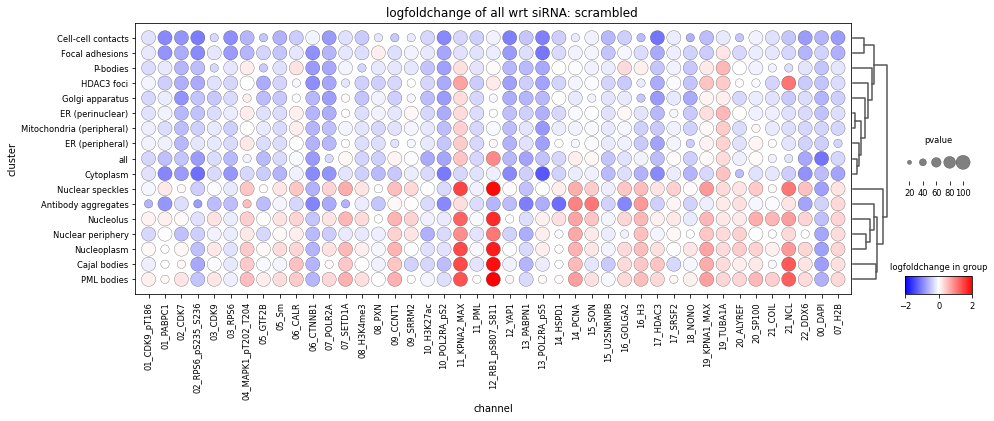

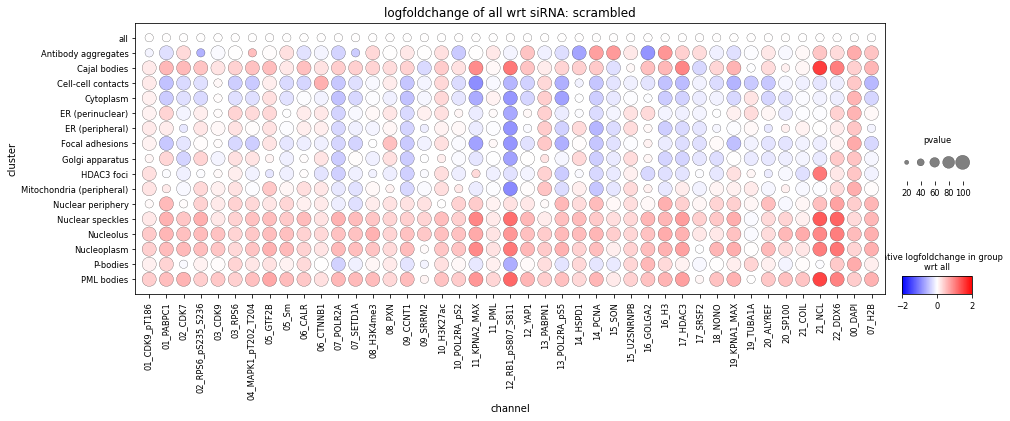

In [5]:
res = get_intensity_change(adata, groupby='cluster', reference_group='siRNA', reference='scrambled', color='logfoldchange', size='pval')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2, dendrogram=True)

res = get_intensity_change(adata, groupby='cluster', reference_group='siRNA', reference='scrambled', color='logfoldchange', size='pval', norm_by_group='all')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2)

## Co-occurence scores

In [6]:
# get combined adata for co-occurrence
adata_co_occ = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')

In [7]:
# plot co-occ score for all cluster pairings
fig, axes = plot_co_occurrence_grid(adata_co_occ, 'siRNA', condition_values=None, legend=False, ci=False, figsize=(20,20))

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f8c1635daf0> (for post_execute):


KeyboardInterrupt: 

## Object statistics

In [ ]:
# aggregate object statistics
for extr in extrs:
    _ = extr.get_object_stats(area_threshold=10, agg=['median'])
# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')


In [ ]:
plot_object_stats(adata_object_stats, group_key='siRNA')